# Анализ рынка вакансий
Выбрать и проанализировать вакансии, на которые студенты QA-факультета могут откликнуться и получить приглашение на интервью. Оценить объём рынка вакансий для начинающих тестировщиков.
### Задача: исследовательский анализ вакансий
1. [Портрет вакансии](#picture)
 - [самые частые требования и задачи](#often)
 - [выделить наиболее популярные сегменты / группы вакансий](#popular_groups)
2. [Анализ аномалий в описании вакансии](#anomaly)
3. [Анализ креативности вакансий](#creativity)

### [Вопросы от заказчика:](#customer)
1. [Емкость рынка по годам.Формат таблицы: Год, Количество вакансий](#years)
2. [Емкость рынка по регионам и по годам.Формат таблицы: Регион, Год, Количество вакансий](#regions)
3. [Доля вакансий, в которой упоминается «исследовательское тестирование»](#research_share)
4. [Распределение по регионам и количество вакансий с удаленной работой.Формат таблицы: Регион, Количество вакансий](#remote)
5. [Существуют ли сезонные пики и спады в распределении числа активных вакансий в течение года и если да — существуют везде или,например, в Москве спадов нет?](#season)
6. [Сколько вакансий-стажировок (с дополнительным к основной выборке словом «стажер»/«стажёр»/«стажировка» в названии) и их распределение по регионам. Формат: Регион, количество вакансий](#trainee)
7. [Сколько вакансий джунов называются «тестировщик», «QA» или«QC»? Не случился ли перекос в сторону наименования QA?](#junior)

### Ожидаемый результат
- Исследовательский анализ данных,
- Ответы на вопросы заказчика с использованием таблиц и инструментов визуализации,
- [Выводы и рекомендации](#conclusions)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Всеволод\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Всеволод\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
vacancy_data = pd.read_csv("C:\project_data\jobs_yandex_prakt.csv", sep='|')

In [5]:
vacancy_data.head(3)

,Unnamed: 0,vacancy_id,vacancy_name,vacancy_description,experience_required,type_of_employment,work_schedule,publication_day,city_name,region_name,country_name,list_of_profarea_ids,list_of_skill_names
0,62986,22432537,Руководитель IT отдела,<p><strong><em>!!!!!!!!!!!УВАЖАЕМЫЕ СОИСКАТЕЛИ...,up_to_6_years,full,full_day,2017-08-30 00:00:00.000,Москва,Москва,Россия,1,[None]
1,1337306,20529248,DevOps engineer,<p><strong>Мы предлагаем полную занятость на у...,up_to_6_years,full,remote,2017-05-15 00:00:00.000,Ставрополь,Ставропольский край,Россия,1,[None]
2,147089,22269077,Разработчик PL/SQL,<p><strong>Требования к соискателям:</strong><...,up_to_3_years,full,full_day,2017-08-08 00:00:00.000,Рязань,Рязанская область,Россия,1,"['Atlassian Jira', 'SOAP', 'Oracle Pl/SQL', 'G..."


Работать с таким огромным датафреймом практически невозможно, выделим интересующие нас вакансии - те, что относятся к тестированию, то есть содержат хотя бы одно из ключевых слов.

In [6]:
vacancy_data['tester'] = 0
vacancy_data['tester'] = vacancy_data.vacancy_name.str.contains('qa|qr|test|тест|quality', case=False).astype(int)

In [7]:
tester_data = vacancy_data.query('tester==1').copy().reset_index()

In [8]:
tester_data.to_csv('tester_data', sep=',', index_label =False)

In [9]:
tester_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22917 entries, 0 to 22916
Data columns (total 15 columns):
index                   22917 non-null int64
Unnamed: 0              22917 non-null int64
vacancy_id              22917 non-null int64
vacancy_name            22917 non-null object
vacancy_description     22917 non-null object
experience_required     22917 non-null object
type_of_employment      22917 non-null object
work_schedule           22917 non-null object
publication_day         22917 non-null object
city_name               22917 non-null object
region_name             20312 non-null object
country_name            22917 non-null object
list_of_profarea_ids    22917 non-null object
list_of_skill_names     22917 non-null object
tester                  22917 non-null int32
dtypes: int32(1), int64(3), object(11)
memory usage: 2.5+ MB


In [10]:
tester_data[tester_data['region_name'].isna()].head()

,index,Unnamed: 0,vacancy_id,vacancy_name,vacancy_description,experience_required,type_of_employment,work_schedule,publication_day,city_name,region_name,country_name,list_of_profarea_ids,list_of_skill_names,tester
3,39,1201893,20553589,QA Automation Engineer,<p>CodeSWAT is looking for QA Automation Engin...,up_to_3_years,full,full_day,2017-05-16 00:00:00.000,Минск,NaN,Беларусь,1,[None],1
13,244,901332,22126277,QA-engineer на мобильные проекты (Middle+/Senior),<p><strong>Apalon - </strong>успешная компания...,up_to_3_years,full,flexible,2017-08-22 00:00:00.000,Минск,NaN,Беларусь,1,"['iOS', 'гайдлайны', 'QA', 'jira', 'Android']",1
26,546,382794,19953044,Специалист по автоматизации тестирования (Java...,<p>Инновационная IT-компания (Agile Java Devel...,up_to_3_years,full,full_day,2017-03-16 00:00:00.000,Минск,NaN,Беларусь,1,"['Jira', 'TestNG', 'Allure', 'Git', 'Stash', '...",1
33,922,1294085,19975365,Главный менеджер управления тестирования вспом...,<p><strong>Основные требования:</strong></p> <...,up_to_6_years,full,full_day,2017-03-18 00:00:00.000,Алматы,NaN,Казахстан,1,[None],1
36,1053,1334304,20388217,Senior QA Engineer,<p>Брестской команде Synesis необходим QA уров...,up_to_6_years,full,full_day,2017-04-28 00:00:00.000,Брест,NaN,Беларусь,1,[None],1


Пропуски есть только в столбце регион - многие не пишут название региона, если в столбце city_name уже указан крупный город, особенно - столица. Такие пропуски можно заполнить просто скопировав название города из соответствующего столбца.

In [11]:
tester_data['region_name'] = tester_data['region_name'].fillna(tester_data['city_name'])

Преобразуем столбец publication_day в формат datetime

In [12]:
tester_data['publication_day'] = pd.to_datetime(tester_data['publication_day']) 
tester_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22917 entries, 0 to 22916
Data columns (total 15 columns):
index                   22917 non-null int64
Unnamed: 0              22917 non-null int64
vacancy_id              22917 non-null int64
vacancy_name            22917 non-null object
vacancy_description     22917 non-null object
experience_required     22917 non-null object
type_of_employment      22917 non-null object
work_schedule           22917 non-null object
publication_day         22917 non-null datetime64[ns]
city_name               22917 non-null object
region_name             22917 non-null object
country_name            22917 non-null object
list_of_profarea_ids    22917 non-null object
list_of_skill_names     22917 non-null object
tester                  22917 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(3), object(10)
memory usage: 2.5+ MB


In [13]:
# добавим столбец даты, месяца и года
tester_data['date'] = tester_data['publication_day'].dt.date
tester_data['year'] = tester_data['publication_day'].dt.year
tester_data['month'] = tester_data['publication_day'].astype('datetime64[M]')

In [14]:
tester_data.head(3)

,index,Unnamed: 0,vacancy_id,vacancy_name,vacancy_description,experience_required,type_of_employment,work_schedule,publication_day,city_name,region_name,country_name,list_of_profarea_ids,list_of_skill_names,tester,date,year,month
0,14,287960,23920048,Тестировщик ПО,<p><strong>Обязанности:</strong></p> <p>- Тест...,no_experience,full,full_day,2017-12-25,Москва,Москва,Россия,1,[None],1,2017-12-25,2017,2017-12-01
1,15,2826,22786768,QA Lead / Automation Lead,<p><strong>Magenta</strong> <strong>Technology...,up_to_6_years,full,full_day,2017-09-19,Самара,Самарская область,Россия,1,"['QA', 'XML', 'автоматизированное тестирование...",1,2017-09-19,2017,2017-09-01
2,36,762452,19385470,Аналитик-тестировщик,<p><strong>Крупный системный интегратор пригла...,up_to_3_years,full,full_day,2017-01-23,Москва,Москва,Россия,1,[None],1,2017-01-23,2017,2017-01-01


In [15]:
tester_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22917 entries, 0 to 22916
Data columns (total 18 columns):
index                   22917 non-null int64
Unnamed: 0              22917 non-null int64
vacancy_id              22917 non-null int64
vacancy_name            22917 non-null object
vacancy_description     22917 non-null object
experience_required     22917 non-null object
type_of_employment      22917 non-null object
work_schedule           22917 non-null object
publication_day         22917 non-null datetime64[ns]
city_name               22917 non-null object
region_name             22917 non-null object
country_name            22917 non-null object
list_of_profarea_ids    22917 non-null object
list_of_skill_names     22917 non-null object
tester                  22917 non-null int32
date                    22917 non-null object
year                    22917 non-null int64
month                   22917 non-null datetime64[ns]
dtypes: datetime64[ns](2), int32(1), int64(4), objec

In [16]:
# сохраним общее число qa вакансий в переменную
total_vacancies = len(tester_data)
total_vacancies

22917

## 1. Портрет вакансии <a id="picture"></a>

#### Прежде чем приступать к анализу вакансий, нужно провести предварительную подготовку для  этого анализа - поработать над столбцом описания вакансии - разложить на отдельные слова, избавиться от тэгов и знаков препинания, провести стемминг.

In [17]:
from bs4 import BeautifulSoup

In [18]:
def kill_html(row):
    return BeautifulSoup(row, "lxml").text

In [19]:
# Удаляем html-теги
tester_data['vacancy_text'] = tester_data['vacancy_description'].apply(kill_html)

In [20]:
# переводим в нижний регистр
tester_data['vacancy_text'] = tester_data['vacancy_text'].str.lower()

In [21]:
punctuations = list(string.punctuation)
punctuations.append('«')
punctuations.append('»')

In [22]:
def to_words(row):
    filtered_sentence = [i for i in nltk.word_tokenize(row) if i not in punctuations]
    return filtered_sentence

In [23]:
# разбиваем на отдельные слова и удаляем знаки препинания
tester_data['vacancy_tokenized'] = tester_data['vacancy_text'].apply(to_words)

In [24]:
# описания есть и на английском, поэтому нужны стоп-слова из обоих языков
stop_words = set(stopwords.words("russian")) | set(stopwords.words("english"))

In [25]:
def filter_stop_words(row):
    return [w for w in row if not w in stop_words]

In [26]:
# удаляем стоп-слова
tester_data['vacancy_cleared'] = tester_data['vacancy_tokenized'].apply(filter_stop_words)

In [27]:
def vacancy_stem(row):
    return [russian_stemmer.stem(w) for w in row]

In [28]:
# проведем стемминг
tester_data['vacancy_stemmed'] = tester_data['vacancy_cleared'].apply(vacancy_stem)

In [29]:
tester_data.head(3)

,index,Unnamed: 0,vacancy_id,vacancy_name,vacancy_description,experience_required,type_of_employment,work_schedule,publication_day,city_name,...,list_of_profarea_ids,list_of_skill_names,tester,date,year,month,vacancy_text,vacancy_tokenized,vacancy_cleared,vacancy_stemmed
0,14,287960,23920048,Тестировщик ПО,<p><strong>Обязанности:</strong></p> <p>- Тест...,no_experience,full,full_day,2017-12-25,Москва,...,1,[None],1,2017-12-25,2017,2017-12-01,обязанности: - тестирование web-сайтов - тести...,"[обязанности, тестирование, web-сайтов, тестир...","[обязанности, тестирование, web-сайтов, тестир...","[обязан, тестирован, wеб-сайт, тестирован, апи..."
1,15,2826,22786768,QA Lead / Automation Lead,<p><strong>Magenta</strong> <strong>Technology...,up_to_6_years,full,full_day,2017-09-19,Самара,...,1,"['QA', 'XML', 'автоматизированное тестирование...",1,2017-09-19,2017,2017-09-01,magenta technology мы - международная продукто...,"[magenta, technology, мы, международная, проду...","[magenta, technology, международная, продуктов...","[magenta, technology, международн, продуктов, ..."
2,36,762452,19385470,Аналитик-тестировщик,<p><strong>Крупный системный интегратор пригла...,up_to_3_years,full,full_day,2017-01-23,Москва,...,1,[None],1,2017-01-23,2017,2017-01-01,крупный системный интегратор приглашает аналит...,"[крупный, системный, интегратор, приглашает, а...","[крупный, системный, интегратор, приглашает, а...","[крупн, системн, интегратор, приглаша, аналити..."


In [30]:
duty_list = tester_data['vacancy_stemmed']
vacancy_duty_list = duty_list.explode().reset_index(drop=True)
vacancy_duty_list.head(3)

0        обязан
1    тестирован
2      wеб-сайт
Name: vacancy_stemmed, dtype: object

Получили столбец с описанием вакансий, где каждая строка - отдельное слово из описания. Теперь можно и поанализировать!

### Cамые частые требования и задачи<a id="often"></a>

In [31]:
vacancy_duty_list_to_screen = vacancy_duty_list.value_counts().head(50).apply(pd.Series)
vacancy_duty_list_to_screen.index

Index(['тестирован', 'работ', 'оп', 'знан', 'разработк', 'команд', 'компан',
       'требован', 'проект', 'офис', 'систем', 'тестов', 'наш', 'продукт',
       'возможн', 'задач', 'услов', 'язык', 'работа', 'приложен', 'процесс',
       'умен', 'пониман', 'документац', 'техническ', 'автоматизац', '•',
       'обязан', 'котор', 'профессиональн', 'тест', 'написан', 'функциональн',
       'результат', 'английск', 'test', 'нов', 'уровн', 'мобильн', 'навык',
       'плат', 'автоматизирова', 'experience', 'заработн', 'анализ', 'график',
       'qa', 'корпоративн', 'участ', 'качеств'],
      dtype='object')

In [32]:
def to_array(row):
    return row.strip('[]').strip().lower().split(', ')

In [33]:
# выкидываем None, разбиваем на отдельные словосочетания и удаляем квадратные скобки
tester_data_skill = tester_data[tester_data['list_of_skill_names']!='[None]']['list_of_skill_names'].apply(to_array)

skill_names = tester_data_skill.explode()
skills = skill_names.value_counts().head(50).apply(pd.Series)
skills.index

Index([''тестирование'', ''функциональное тестирование'', ''qa'', ''sql'',
       ''тестирование пользовательского интерфейса'', ''java'', ''test case'',
       ''регресcионное тестирование'', ''atlassian jira'', ''python'',
       ''linux'', ''git'', ''selenium ide'', ''нагрузочное тестирование'',
       ''английский язык'', ''javascript'', ''проведение тестирований'',
       ''html'', ''c#'', ''selenium'', ''jenkins'', ''css'', ''ms sql'',
       ''android'', ''xml'', ''ios'', ''scrum'', ''rest'', ''php'', ''mysql'',
       ''работа в команде'', ''модульное тестирование'', ''ооп'', ''api'',
       ''ручное тестирование'', ''регресионное тестирование'',
       ''автоматизированное тестирование'', ''black box testing'',
       ''postgresql'', ''jmeter'', ''c++'', ''unit testing'',
       ''автоматизация тестирования'', ''soap'', ''разработка по'',
       ''atlassian confluence'', ''redmine'', ''jira'', ''junit'', ''unix''],
      dtype='object')

В топе, конечно, самые общие фразы - тестирование, опыт, команда разработчиков, проект, офис (уютный и в шаговой доступности) и т.д.
А вот пониже в списке уже есть что-то полезное. Знание языка (как правило, английского), понимание технической документации, навыки работы(sql, java, jira, selenium, python), автоматизированное тестирование, тестирование мобильных приложений, ручное тестирование, оформление по ТК РФ.

Требуемые навыки можно посмотреть еще в столбце list_of_skill_names. Топ требований: 'тестирование', 'функциональное тестирование', 'qa', 'sql', 'тестирование пользовательского интерфейса', 'java', 'test case', 'регресcионное тестирование', 'atlassian jira', 'python', 'linux', 'git', 'selenium ide', 'нагрузочное тестирование', 'английский язык'.

### Выделить наиболее популярные сегменты / группы вакансий <a id="popular_groups"></a>

По опыту, по рабочему расписанию, по типу занятости

In [34]:
groups = {
    'experience_required': 'Требуемый опыт',
    'work_schedule': 'Режим работы',
    'type_of_employment': 'Тип занятости'
}

In [35]:
ticks = {
    'experience_required' : ['до 3 лет', 'до 6 лет', 'без опыта', 'свыше 6 лет'],
    'work_schedule': ['полный', 'гибкий', 'удалённый', 'сменный', 'вахтовый'],
    'type_of_employment': ['полная', 'частичная', 'испытательный срок', 'проектная', 'волонтер']
}

Требуемый опыт
up_to_3_years    14631
up_to_6_years     5062
no_experience     2918
above_6_years      306
Name: experience_required, dtype: int64


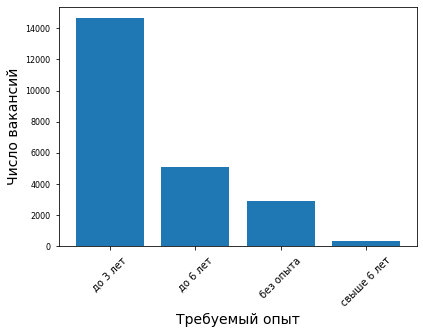

Режим работы
full_day       18997
flexible        2198
remote          1660
shift             56
flyInFlyOut        6
Name: work_schedule, dtype: int64


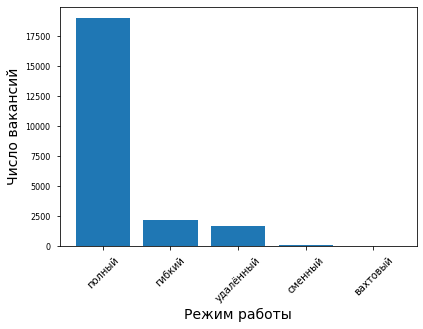

Тип занятости
full         22009
part           611
probation      188
project        105
volonteer        4
Name: type_of_employment, dtype: int64


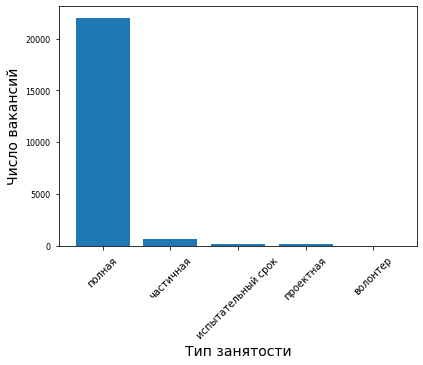

In [36]:
for key in groups:
    print(groups[key])
    print(tester_data[key].value_counts())
    group_data = (tester_data.groupby(key, as_index=False)[['vacancy_id']].count()
                .sort_values(by='vacancy_id', ascending=False).rename(columns={'vacancy_id':'vacancy_quant'}))
    with plt.style.context('seaborn-paper'):
        plt.bar(ticks[key], group_data['vacancy_quant'])
    plt.xlabel(groups[key], fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylabel('Число вакансий', fontsize=14)
    plt.show()

#### Вывод
Коронавирус коронавирусом, но подавляющее большинство работодателей (83%) хотят видеть работника в офисе с 9 до 18 5 дней в неделю.

## 2. Анализ аномалий в описании вакансии <a id="anomaly"></a>

Полагаю,  в этом разделе предполагался анализ зарплат на наличие выбросов, сравнение зарплат в зависимости от уровня квалификации, нет ли вакансий джунов с зарплатой выше миддла и т.д. Но в полученном массиве данных о зарплатах не оказалось.

Поэтому остается искать расхождения между  type_of_employment и work_schedule или требованиям к опыту (считаем аномалией требовать с джуна опыт работы 6 лет или прием на работу сениора без опыта).


In [37]:
# приглашают соискателя на полный день, при этом занятость указана как частичная
tester_data[(tester_data['work_schedule'] == 'full_day') & (tester_data['type_of_employment'] == 'part')]
schedule_anomaly= len(tester_data[(tester_data['work_schedule'] == 'full_day') & (tester_data['type_of_employment'] == 'part')])
schedule_anomaly

14

In [38]:
tester_data['junior'] = 0
tester_data['junior'] = (tester_data.vacancy_name.str.contains('junior|младший|джун', case=False) |
                        tester_data.vacancy_description.str.contains('junior|младший|джун', case=False)).astype(int)

In [39]:
junior_data = tester_data.query('junior==1').copy().reset_index()
junior_data = junior_data.drop(columns='junior')

In [40]:
# приглашают джуна с чрезмерно большим опытом работы
overexperied_juniors = len(junior_data[(junior_data['experience_required'] == 'up_to_6_years') | (junior_data['experience_required'] == 'above_6_years')])
overexperied_juniors

53

In [41]:
tester_data['middle_senior'] = 0

tester_data['middle_senior'] = (tester_data.vacancy_name.str.contains('middle|senior|ведущий|старший', case=False) |
                        tester_data.vacancy_description.str.contains('middle|senior|ведущий|старший', case=False)).astype(int)

middle_senior_data = tester_data.query('middle_senior==1').copy().reset_index()
middle_senior_data = middle_senior_data.drop(columns='middle_senior')

In [42]:
# приглашают миддла/сениора без опыта работы
middle_senior_no_exp = len(middle_senior_data[(middle_senior_data['experience_required'] == 'no_experience')])
middle_senior_no_exp

182

In [43]:
# доля аномалий
(schedule_anomaly + overexperied_juniors + middle_senior_no_exp)/total_vacancies

0.010865296504778112

Найденные аномалии составляют всего 1% от всего массива данных по тестировщикам.

## 3. Анализ креативности вакансий <a id="creativity"></a>

Не очень понятный мне пункт. Имеется в виду креативность составления объявления о вакансии или о креативности рабочей позиции. Если второе - то как его оценивать по объявлению? Если первое - то можем поискать в описании вакансии необычные слова.

In [44]:
creative = ['вкусн','футбол', 'праздник', 'крут', 'фрукт', 'фитнес', 'настольн', 'поэт', 'кикер', 'велопарковк', 'плюшк', 
            'ярк', 'массаж', 'туризм', 'playstation']

In [45]:
creative_join = '|'.join(creative)
creative_data = tester_data.query('vacancy_description.str.contains(@creative_join, case=False)', engine='python')

In [46]:
# всего "креативных" вакансий
creative_vacancies = len(creative_data)
creative_vacancies

7502

In [47]:
# доля
creative_vacancies/total_vacancies

0.3273552384692586

По времени

In [48]:
#creative_data
creative_per_season = creative_data.groupby(['month'], as_index=False)[['vacancy_id']].count().rename(columns={'vacancy_id':'vacancy_quant'})
#creative_per_season.head()

In [49]:
vacancy_per_season = tester_data.groupby(['month'], as_index=False)[['vacancy_id']].count().rename(columns={'vacancy_id':'total_quant'})
vacancy_per_season.head()

,month,total_quant
0,2017-01-01,551
1,2017-02-01,542
2,2017-03-01,671
3,2017-04-01,655
4,2017-05-01,654


In [50]:
creative_per_season = creative_per_season.merge(vacancy_per_season, on='month', how='left')
creative_per_season['creative_share'] = creative_per_season['vacancy_quant'] / creative_per_season['total_quant']
creative_per_season.head(3)

,month,vacancy_quant,total_quant,creative_share
0,2017-01-01,182,551,0.330309
1,2017-02-01,164,542,0.302583
2,2017-03-01,206,671,0.307004


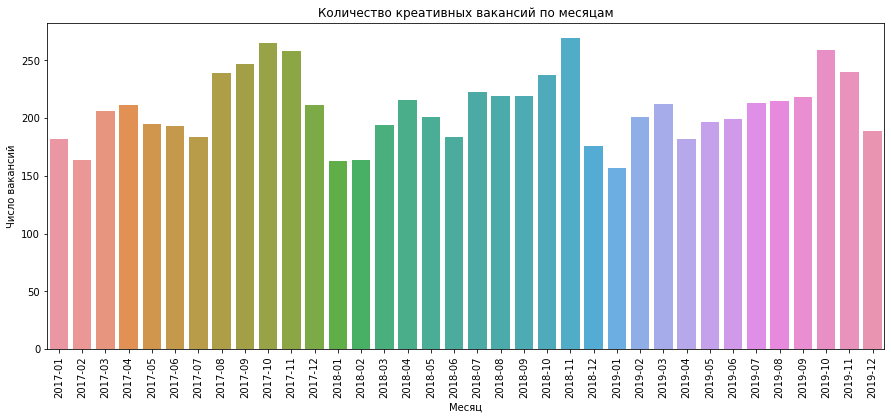

In [51]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
plt.title('Количество креативных вакансий по месяцам')
ax = sns.barplot(x="month", y="vacancy_quant", data=creative_per_season)
ax.set_xticklabels([i.strftime('%Y-%m') for i in creative_per_season.month]);
ax.set(xlabel='Месяц', ylabel='Число вакансий')
plt.show()

Общее количество креативных вакансий подвержено сезонным колебаниям (для общего числа вакансий мы подробнее проанализируем их ниже) - рост в конце лета/осенью, падение в начале года и в мае-июне.

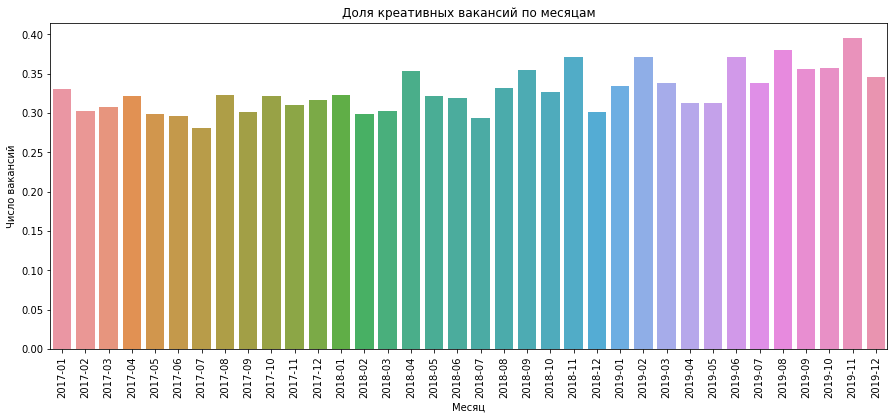

In [52]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
plt.title('Доля креативных вакансий по месяцам')
ax = sns.barplot(x="month", y="creative_share", data=creative_per_season)
ax.set_xticklabels([i.strftime('%Y-%m') for i in creative_per_season.month]);
ax.set(xlabel='Месяц', ylabel='Число вакансий')
plt.show()

А вот доля таких вакансий от общего числа потихонечку растет со временем - за 3 года примерно на 10%.

### Выводы
Около трети вакансий составлены с "креативным" подходом. Видимо, работодатели надеются заполучить к себе таких же нестандартных ребят ))

## Вопросы от Заказчика <a id="customer"></a>

#### 1. Емкость рынка по годам.Формат таблицы: Год, Количество вакансий <a id="years"></a>

In [53]:
vacancy_per_year = tester_data.groupby('year', as_index=False)[['vacancy_id']].count().rename(columns={'vacancy_id':'vacancy_quant'})
vacancy_per_year

,year,vacancy_quant
0,2017,8262
1,2018,7580
2,2019,7075


Общее количество вакансий в области тестирования немного, но снижается с годами - на 8% в 2018 относительно 2017 и еще на 7% в 2019 относительно 2018.

#### 2. Емкость рынка по регионам и по годам.Формат таблицы: Регион, Год, Количество вакансий <a id="regions"></a>

In [54]:
vacancy_per_region = tester_data.groupby(['region_name', 'year'], as_index=False)[['vacancy_id']].count().sort_values(by='vacancy_id', ascending=False).rename(columns={'vacancy_id':'vacancy_quant'})
vacancy_per_region

,region_name,year,vacancy_quant
108,Москва,2017,2587
110,Москва,2019,2488
109,Москва,2018,2399
201,Санкт-Петербург,2017,1506
202,Санкт-Петербург,2018,1254
...,...,...,...
185,Республика Северная Осетия-Алания,2019,1
189,Республика Тыва,2018,1
191,Республика Хакасия,2019,1
20,Барановичи,2019,1


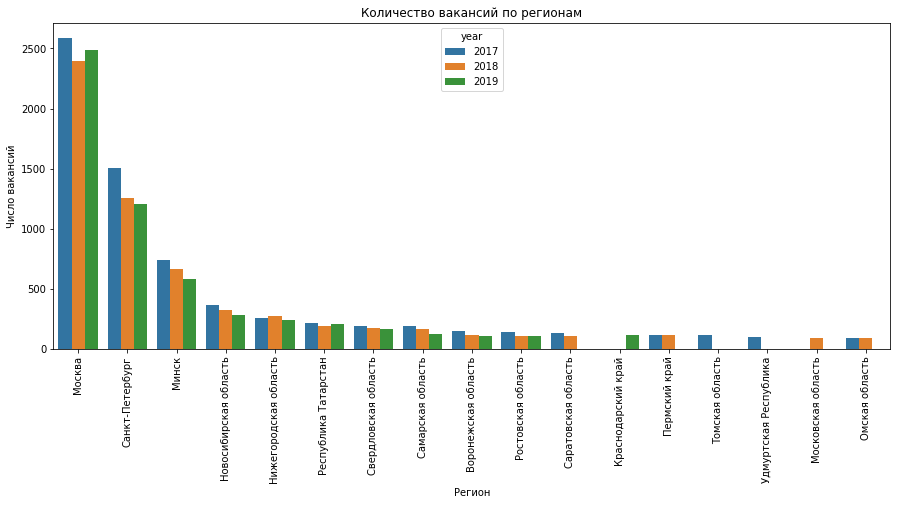

In [55]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
plt.title('Количество вакансий по регионам')
ax = sns.barplot(x="region_name", y="vacancy_quant", hue='year', data=vacancy_per_region.head(40))
ax.set(xlabel='Регион', ylabel='Число вакансий')
plt.show()

Тенденция к снижению числа вакансий просматривается и по данным регионов. Кое-где (Ростов, Саратов, Пермь) они вовсе сходят на нет после 2017го года. Исключением выглядит Москва, где после падения числа вакансий в 2018м на 7%, в 2019м произошел отскок на 3,7%.

#### 3. Доля вакансий, в которой упоминается «исследовательское тестирование» <a id="research_share"></a>

In [56]:
tester_data['research'] = 0

In [57]:
tester_data['research'][tester_data['vacancy_description'].str.contains('исследовательск', case=False)] = 1

In [58]:
tester_data['research'].sum() / len(tester_data)

0.04149757821704412

##### Около 4% от общего числа вакансий в области тестирования

#### 4. Распределение по регионам и количество вакансий с удаленной работой. Формат таблицы: Регион, Количество вакансий <a id="remote"></a>

In [59]:
remote_data = tester_data.query('work_schedule=="remote"').copy().reset_index()

In [60]:
remote_data_per_region = remote_data.groupby(['region_name'], as_index=False)[['vacancy_id']].count().sort_values(by='vacancy_id', ascending=False).rename(columns={'vacancy_id':'vacancy_quant'})
remote_data_per_region

,region_name,vacancy_quant
36,Москва,360
67,Санкт-Петербург,162
61,Республика Татарстан,62
39,Нижегородская область,59
41,Новосибирская область,56
...,...,...
5,Атырау,1
50,Республика Адыгея,1
9,Витебск,1
7,Брест,1


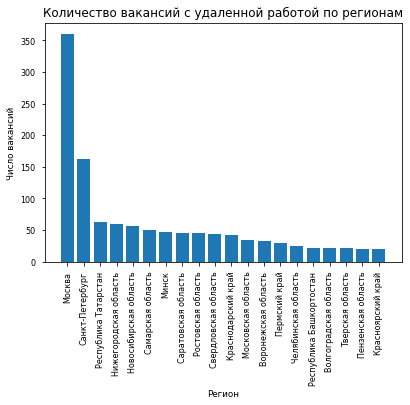

In [61]:
with plt.style.context('seaborn-paper'):
    plt.bar(remote_data_per_region.head(20)['region_name'], remote_data_per_region.head(20)['vacancy_quant'])
plt.xlabel('Регион')
plt.ylabel('Число вакансий')
plt.title('Количество вакансий с удаленной работой по регионам')
plt.xticks(rotation=90)     
plt.show()

<a id="season"></a>
#### 5. Существуют ли сезонные пики и спады в распределении числа активных вакансий в течение года и если да — существуют везде или,например, в Москве спадов нет? 

In [62]:
#vacancy_per_season = tester_data.groupby(['month'], as_index=False)[['vacancy_id']].count().rename(columns={'vacancy_id':'vacancy_quant'})  #.sort_values(by='month')
vacancy_per_season.head(3)

,month,total_quant
0,2017-01-01,551
1,2017-02-01,542
2,2017-03-01,671


In [63]:
#vacancy_per_season['month'] = pd.to_datetime(vacancy_per_season['month'], format='%Y-%m-%d')
#vacancy_per_season.head()

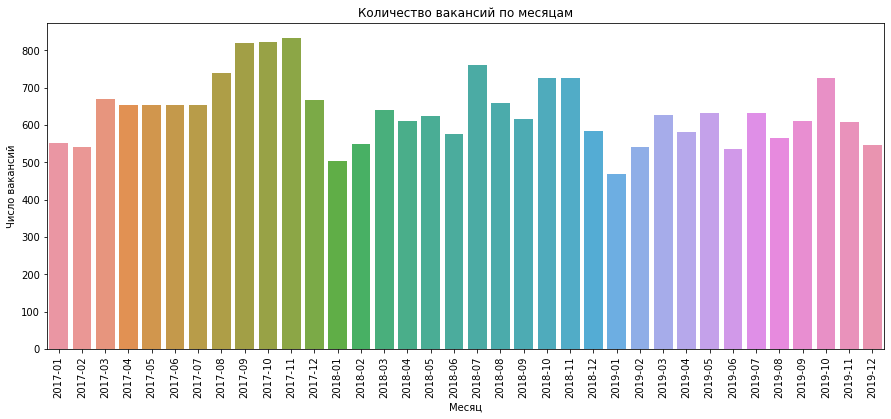

In [64]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
plt.title('Количество вакансий по месяцам')
ax = sns.barplot(x="month", y="total_quant", data=vacancy_per_season)
ax.set_xticklabels([i.strftime('%Y-%m') for i in vacancy_per_season.month]);
ax.set(xlabel='Месяц', ylabel='Число вакансий')
plt.show()

По общему массиву вакансий сезонные колебания явно есть - отчетливо просматривается рост их числа в конце лета-осенью и провал в зимние месяцы. Возможно, это связано с тем, что летом в большинстве ВУЗов происходит защита дипломов и компании начинают охоту на перспективных выпускников. Зимой же, особенно в районе нового года, деловая активность вообще снижается, брать новых сотрудников в этот период хотят далеко не все.

Впрочем, в 2019м эти колебания немного сглаживаются.

In [65]:
# Рассмотрим что происходит с сезонными колебаниями в топ-10 регионов
top_cities = vacancy_per_region['region_name'].drop_duplicates().head(10)

In [66]:
vacancy_per_season_region = tester_data.groupby(['month', 'region_name'], as_index=False)[['vacancy_id']].count().rename(columns={'vacancy_id':'vacancy_quant'})
#vacancy_per_season_region

Москва


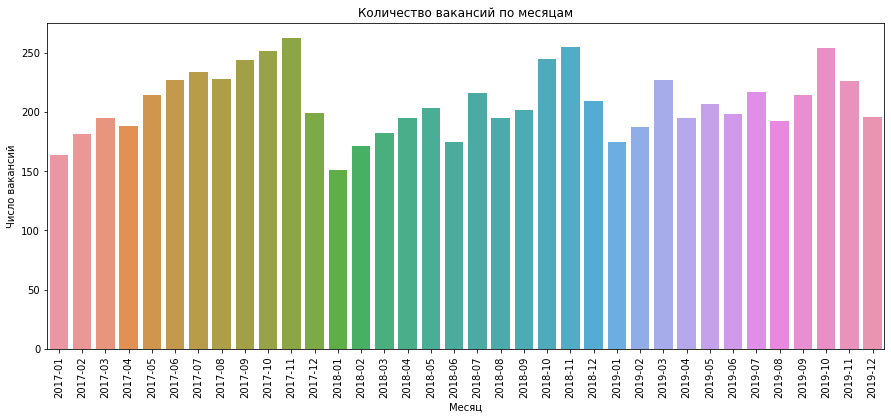

Санкт-Петербург


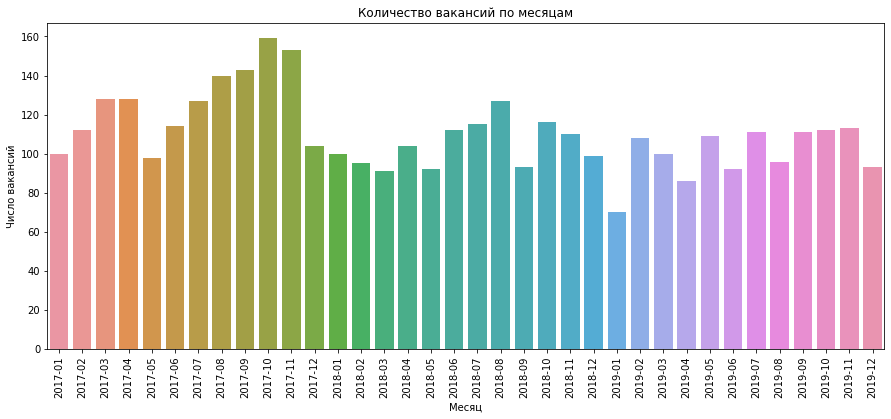

Минск


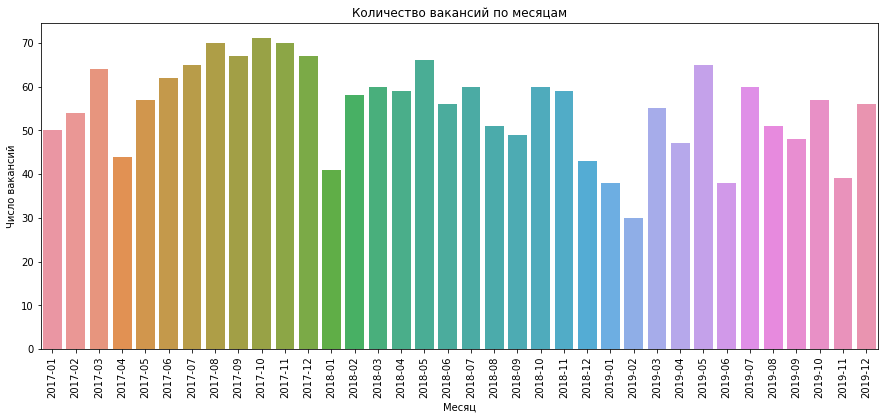

Новосибирская область


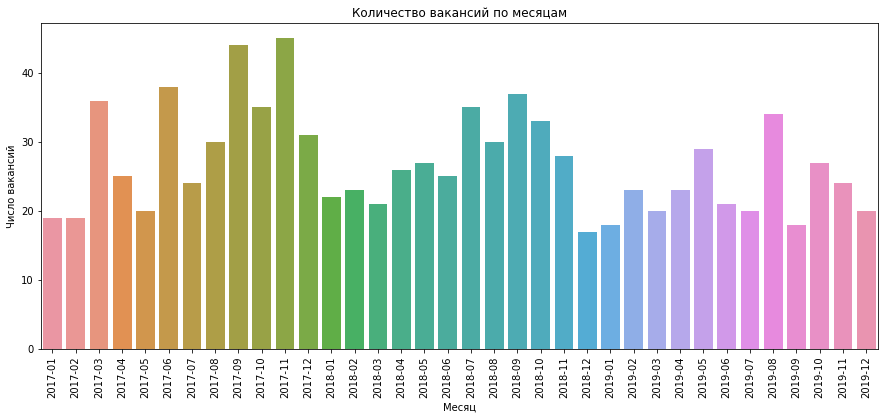

Нижегородская область


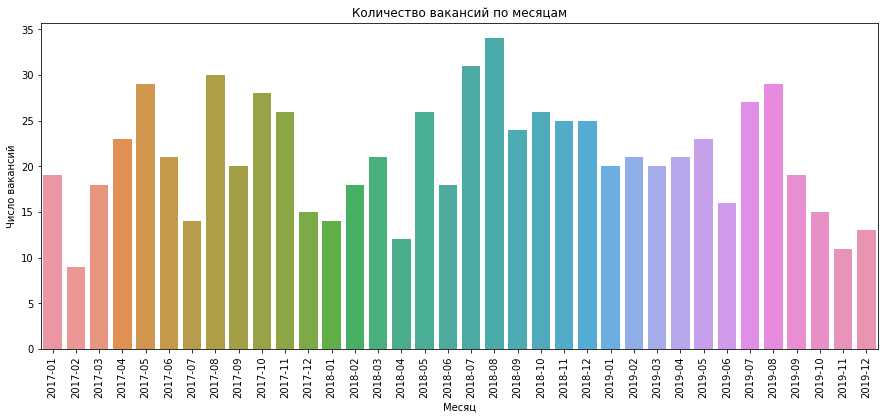

Республика Татарстан


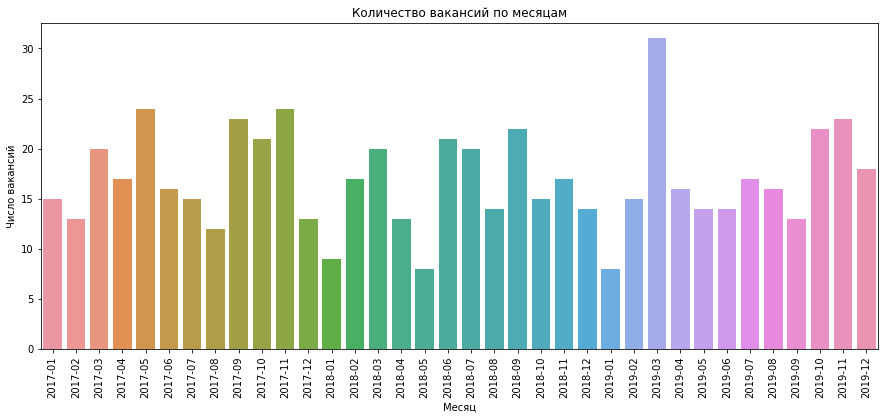

Свердловская область


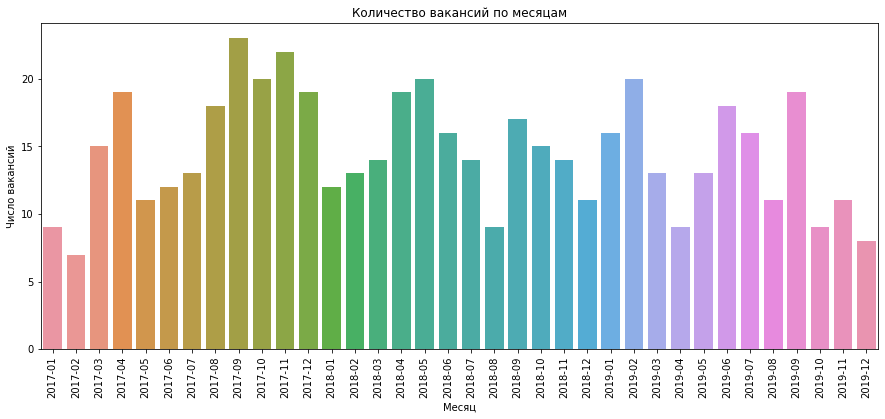

Самарская область


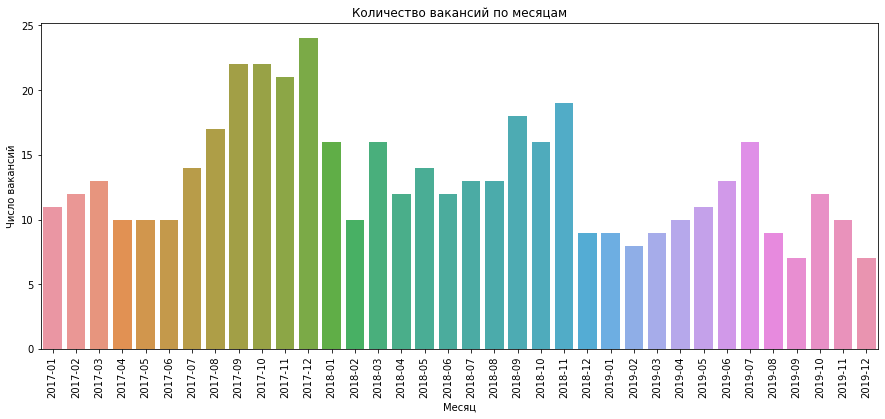

Воронежская область


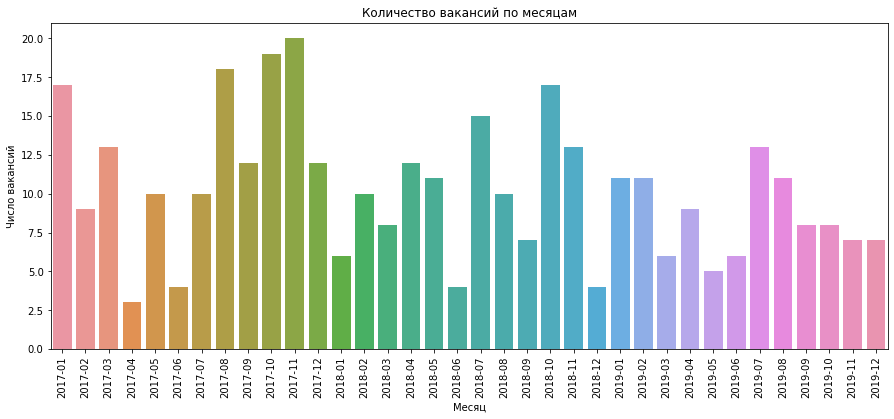

Ростовская область


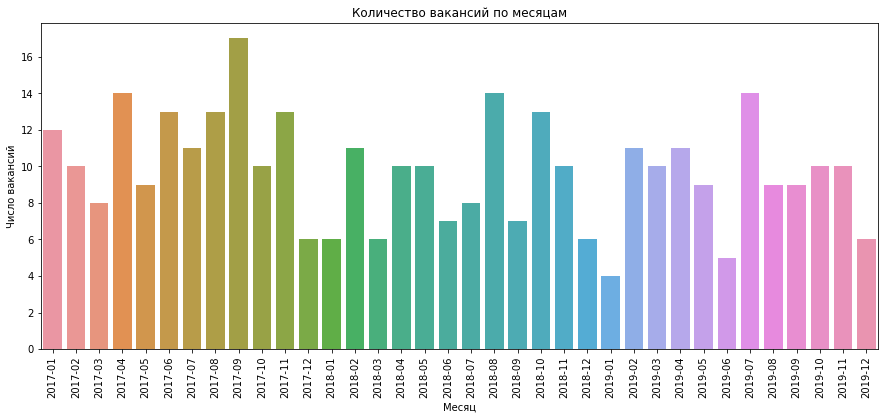

In [67]:
for region in top_cities:
    print(region)
    graph_data = vacancy_per_season_region[vacancy_per_season_region['region_name']==region]
    plt.figure(figsize=(15, 6))
    plt.xticks(rotation=90)
    plt.title('Количество вакансий по месяцам')
    ax = sns.barplot(x="month", y="vacancy_quant", data=graph_data)
    ax.set_xticklabels([i.strftime('%Y-%m') for i in graph_data.month]);
    ax.set(xlabel='Месяц', ylabel='Число вакансий')
    plt.show()
    

Что ж, подобные колебания есть во всех регионах, хотя и выглядят где-то более ярко выраженно, где-то более сглаженно (Москва, Минск, СПб).

<a id="trainee"></a>
#### 6. Сколько вакансий-стажировок (с дополнительным к основной выборке словом «стажер»/«стажёр»/«стажировка» в названии) и их распределение по регионам/ Формат: Регион, количество вакансий 

In [68]:
tester_data['trainee'] = 0

In [69]:
tester_data['trainee'] = (tester_data.vacancy_name.str.contains('стажер|стажёр|стажиров|trainee', case=False) |
                        tester_data.vacancy_description.str.contains('стажер|стажёр|стажиров|trainee', case=False)).astype(int)

In [70]:
trainee_data = tester_data.query('trainee==1').copy().reset_index()

In [71]:
len(trainee_data)

614

#### Всего 614 таких вакансий

In [72]:
trainee_data_per_region = trainee_data.groupby(['region_name'], as_index=False)[['vacancy_id']].count().sort_values(by='vacancy_id', ascending=False).rename(columns={'vacancy_id':'vacancy_quant'})
trainee_data_per_region.head(20)

,region_name,vacancy_quant
20,Москва,154
43,Санкт-Петербург,97
8,Воронежская область,36
52,Удмуртская Республика,27
18,Минск,27
25,Новосибирская область,24
22,Нижегородская область,20
39,Республика Татарстан,20
45,Свердловская область,19
41,Рязанская область,14


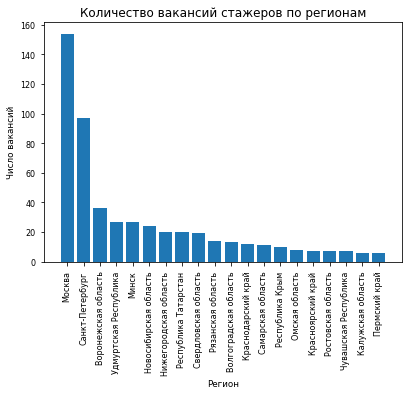

In [73]:
with plt.style.context('seaborn-paper'):
    plt.bar(trainee_data_per_region['region_name'].head(20), trainee_data_per_region['vacancy_quant'].head(20))
plt.xlabel('Регион')
plt.ylabel('Число вакансий')
plt.title('Количество вакансий стажеров по регионам')
plt.xticks(rotation=90)     
plt.show()

С Москвой и СПб все понятно, но любопытно, что за ними идут не айтишный Минск или Новосибирск, а Воронеж и Ижевск. Неужели там начинает развиваться IT-индустрия?

<a id="junior"></a>
#### 7. Сколько вакансий джунов называются «тестировщик», «QA» или«QC»? Не случился ли перекос в сторону наименования QA? 

In [74]:
len(junior_data)

1186

In [75]:
for name in {'QA', 'QC', 'тестировщик'}:
    junior_named = len(junior_data[junior_data['vacancy_name'].str.contains(name, case=False)])
    print('Название', name, 'встречается', junior_named, 'раз')

Название QA встречается 675 раз
Название тестировщик встречается 393 раз
Название QC встречается 7 раз


Что ж, перекос в сторону QA действительно есть и довольно значительный - встречается вдвое чаще, чем "тестировщик", а частота QC вообще исчезающе мала. Возможно, работодатели считают, что джуну еще рано знать что такое Quality Control.

### Выводы и рекомендации <a id="conclusions"></a>

Общее количество вакансий в области тестирования немного, но снижается с годами - на 8% в 2018 относительно 2017 и еще на 7% в 2019 относительно 2018.
Тенденция к снижению числа вакансий просматривается и по данным регионов. Кое-где (Ростов, Саратов, Пермь) они вовсе сходят на нет после 2017го года. Исключением выглядит Москва, где после падения числа вакансий в 2018м на 7%, в 2019м произошел отскок на 3,7%.

Лишь около 4% от общего числа составляют вакансии, где требуется навык исследовательского тестирования.

По количеству удаленных вакансий лидируют Москва, СПб, Татарстан, Н.Новгород, Новосибирск. Любопытно, что идущий на уверенном 3м месте по общему числу вакансий Минск, по возможностям удаленной работы лишь седьмой. Хочешь работать в World of Tanks - переезжай в Минск.

По общему массиву вакансий сезонные колебания явно есть - отчетливо просматривается рост их числа в конце лета-осенью и провал в зимние месяцы. Возможно, это связано с появлением на рынке в это время выпускников ВУЗов. Зимой же, особенно в районе нового года, деловая активность вообще снижается, брать новыхсотрудников в этот период хотят далеко не все.
И подобные колебания есть во всех регионах, хотя и выглядят где-то более ярко выраженно, где-то более сглаженно (Москва, Минск, СПб).

Вакансий для стажеров всего 614 на весь массив, это примерно 2,5%. Как всегда, в основном это Моква и Питер, но неожиданно 3й и 4й - Воронеж и Ижевск.

Название QC встречается 7 раз
Название тестировщик встречается 393 раз
Название QA встречается 675 раз
В названиях вакансий для младших тестировщиков есть очень большой перекос в сторону QA, эта аббревиатура встречается вдвое чаще, чем "тестировщик", а уж частота QC вообще исчезающе мала.

"Креативные" вакансии я определил по встречающимся в описании нестандартным словам, например -  ''футбол', 'праздник', 'крут', 'фрукт', 'поэт', 'кикер', 'велопарковк', 'плюшк' и т.д. Таких вакансий оказалось около 32%, но их доля от общего числа медленно, но верно растет - за 3 года примерно на 10%.

##### Таким образом, выпускнику QA факультета можно порекомендовать следующее:
- Искать работу в Москве и СПБ (к сожалению, это относится к почти любой профессии в нашей стране), также можно рассмотреть Минск, но только если вы готовы туда переехать - возможность удаленной работы братья-белорусы рассматривают неохотно.
- Если хочется попробовать найти удаленную должность, то, кроме двух столиц, можно обратить внимание на Татарстан, Н.Новгород и Новосибирск.
- Стажировка доступна еще в Воронеже и Ижевске.
- Для поиска работы лучшими месяцами являются июль-август-сентябрь, а это очень скоро, терять времени не следует!
- В резюме стоит использовать QA, чтобы увеличить вероятность попадания его на глаза HR.


Типичная вакансия  - это опыт от 3х лет, полная занятость, полный рабочий день. А самые востребованнные навыки, про которые вероятнее всего вас спросят на собеседовании - функциональное тестирование, тестирование пользовательского интерфейса, регресcионное и нагрузочное тестирование,  sql, java, atlassian jira, python, linux, git, selenium ide. 
И, конечно, английский. Если не найдете работу, по крайней мере, сможете смотреть сериалы в оригинале.